<a href="https://colab.research.google.com/github/auksasful/free-chatgpt-js/blob/main/AML_MP2_Sta%C5%A1kevi%C4%8Dius.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MP2: Deep Fast Road Signs

Date: 2024.[11.22]

Solution author: © 2024 [[Your Name]](our.contact.info)  
Template author: © 2024 [Mantas Lukoševičius](https://mantas.info/)

This notebook is part of an individual project for [KTU IF](https://fi.ktu.edu/)  [P176M010 Advanced Machine Learning](https://admissions.ktu.edu/programme/m-software-engineering/#P176M010) class led by [M. Lukoševičius](http://mantas.info/).

You should only eddit this notebook where it is allowed, comment on all of your improvements in markdown cells and in your presentation.

The goal is to train a [PyTorch](https://pytorch.org/)-based [German Traffic Sign Recognition Benchmark (GTSRB)](https://benchmark.ini.rub.de/gtsrb_dataset.html) classifier in under 2 minutes for maximum classification accuracy. We use a subset of the benchmark that was used in the [IJCNN 2011 competition](https://benchmark.ini.rub.de/gtsrb_results.html).

This template is partially based on [this tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

The performance will be measured on **Tesla T4** graphics card on Google Colab machines. You should select GPU in Google Colab: `Runtime` -> `Change runtime type` -> `Hardware accelerator: T4 GPU`. Beware of free [GPU usage limits in Colab](https://research.google.com/colaboratory/faq.html#usage-limits), don't try to do all the work in one day.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random

## Settings

Do not eddit!

On the reproducibility of experiments: https://pytorch.org/docs/stable/notes/randomness.html

In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


## Information on the obtained hardware

In [ ]:
print('Torch version: %s' %torch.__version__)
if torch.cuda.is_available():
    print('GPU: %s' %torch.cuda.get_device_name())
else:
    print('GPU not available.')

Torch version: 2.4.1+cu121
GPU: Tesla T4


In [ ]:
!nvidia-smi

Tue Oct 22 16:54:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!lscpu

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   2
  On-line CPU(s) list:    0,1
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:           6
    Model:                79
    Thread(s) per core:   2
    Core(s) per socket:   1
    Socket(s):            1
    Stepping:             0
    BogoMIPS:             4399.99
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 cl
                          flush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc re
                          p_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3
                           fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand
                           hypervisor lahf_lm abm 3dnowprefetch i

## Import the data and show some examples

This transformation is just for data visualization.

In [ ]:
# download and load training dataset for demo plotting
demo_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
    ])
demo_dataset = torchvision.datasets.GTSRB(root='./data', split='train',
                                        transform=demo_transform, download=True )
nclasses = 43

100%|██████████| 187490228/187490228 [00:08<00:00, 23033720.10it/s]


Extracting data/gtsrb/GTSRB-Training_fixed.zip to data/gtsrb


Show some imput images.

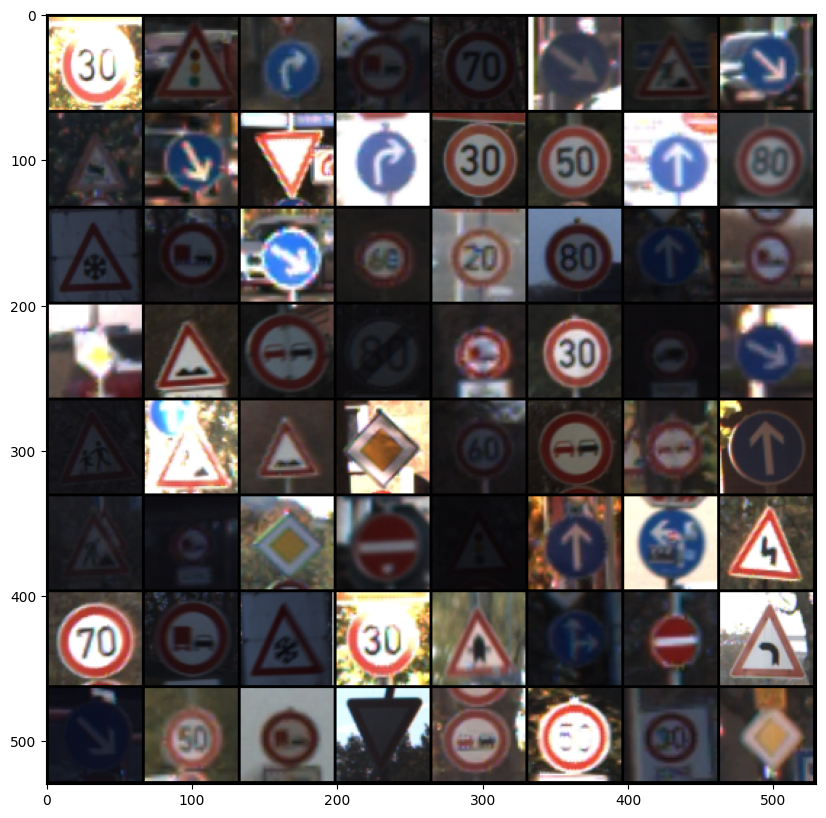

In [ ]:
import matplotlib.pyplot as plt

## functions to show an image
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
demoloader = torch.utils.data.DataLoader(demo_dataset, batch_size=64,
                                          shuffle=True, num_workers=2)
dataiter = iter(demoloader)
images, labels = next(dataiter)

## show images
plt.figure(figsize=(10,10))
imshow(torchvision.utils.make_grid(images))

## My models

<span style="color:red">This is the main section which you should rewrite and expand significanlty providing/documenting your models tried and results with them.</span>

They all have to be Pytorch models that solve the GTSRB task.

You can go wild here!

Some methods (code and describing papers) for the dataset can be found at https://paperswithcode.com/sota/traffic-sign-recognition-on-gtsrb, or ideas at https://benchmark.ini.rub.de/gtsrb_results.html. Note, however, that most of the solutions are too big and slow for our rules of the game.

Other solutions can be found online, adopted from similar datasets, like for example [CIFAR-10](https://paperswithcode.com/sota/image-classification-on-cifar-10). I have included several starters here and have tested some of them. Beware of name clashes when you copy code. Remove the unoriginal models from this notebook that you don't investigate.

Your original architectures and modifications are the most welcome, of course!




### From the official PyTorch tutorial

Adapted from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html. The tutorial was for CIFAR-10 dataset (also 32x32 input) so we only changed the output dimensions of the model (10->43 classes).

In [ ]:
class TuNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, nclasses)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Adopter from [gautam-sharma1](https://github.com/gautam-sharma1)

From https://github.com/gautam-sharma1/GTSRB-torch

In [ ]:
class GSNet(nn.Module):
    def __init__(self):
        super(GSNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 100, 5)
        self.conv1_bn = nn.BatchNorm2d(100)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(100, 150, 3)
        self.conv2_bn = nn.BatchNorm2d(150)

        self.conv3 = nn.Conv2d(150, 250, 1)
        self.conv3_bn = nn.BatchNorm2d(250)

        self.fc1 = nn.Linear(250 * 3 * 3, 350)
        self.fc1_bn = nn.BatchNorm1d(350)

        self.fc2 = nn.Linear(350, nclasses)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        '''
        Layer 1
        '''
        x = self.pool(F.elu(self.conv1(x)))
        x = self.dropout(self.conv1_bn(x))

        '''
        Layer 2
        '''
        x = self.pool(F.elu(self.conv2(x)))
        x = self.dropout(self.conv2_bn(x))

        '''
        Layer 3
        '''
        x = self.pool(F.elu(self.conv3(x)))
        x = self.dropout(self.conv3_bn(x))

        '''
        Layer 4
        '''
        x = x.view(-1, 250 * 3 * 3)
        x = F.elu(self.fc1(x))

        '''
        Layer 5
        '''
        x = self.dropout(self.fc1_bn(x))
        x = self.fc2(x)
        return x

### [Kentaro Yoshioka](https://github.com/kentaroy47)'s ResNet implementations

From https://github.com/kentaroy47/pytorch-cifar10-fp16

In [ ]:
# -*- coding: utf-8 -*-

'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=nclasses):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])


def test():
    net = ResNet18()
    y = net(torch.randn(1,3,32,32))
    print(y.size())

# test()

### MicroNet by [Priyank Pathak](https://github.com/ppriyank)

From https://github.com/ppriyank/MicronNet/, described in https://arxiv.org/abs/1804.00497v3. Requires 48x48 input size.

In [ ]:
class MicroNet(nn.Module):
    def __init__(self):
        super(MicroNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 1, kernel_size=1)
        self.conv2 = nn.Conv2d(1, 29, kernel_size=5)
        self.maxpool2 = nn.MaxPool2d(3, stride=2 , ceil_mode=True)
        self.conv3 = nn.Conv2d(29, 59, kernel_size=3)
        self.maxpool3 = nn.MaxPool2d(3, stride=2 , ceil_mode=True)
        self.conv4 = nn.Conv2d(59, 74, kernel_size=3)
        self.maxpool4 = nn.MaxPool2d(3, stride=2 , ceil_mode=True)
        self.conv2_drop = nn.Dropout2d()
        self.conv3_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1184, 300)
        self.fc2 = nn.Linear(300, nclasses)
        self.conv0_bn = nn.BatchNorm2d(3)
        self.conv1_bn = nn.BatchNorm2d(1)
        self.conv2_bn = nn.BatchNorm2d(29)
        self.conv3_bn = nn.BatchNorm2d(59)
        self.conv4_bn = nn.BatchNorm2d(74)
        self.dense1_bn = nn.BatchNorm1d(300)
    def forward(self, x):
        x =  F.relu(self.conv1_bn(self.conv1(self.conv0_bn(x))))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3( self.maxpool2(x))))
        x = F.relu(self.conv4_bn(self.conv4( self.maxpool3(x))))
        x = self.maxpool4(x)
        x = x.view(-1, 1184)
        x = F.relu(self.fc1(x))
        x = self.dense1_bn(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.dropout(x, training=self.training)
        return F.log_softmax(x)

### Ayoosh Kathuria's ResNet example

From https://blog.paperspace.com/pytorch-101-building-neural-networks/, have not tested it yet.

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # Conv Layer 1
        self.conv1 = nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels,
            kernel_size=(3, 3), stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Conv Layer 2
        self.conv2 = nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=(3, 3), stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection to downsample residual
        # In case the output dimensions of the residual block is not the same
        # as it's input, have a convolutional layer downsample the layer
        # being bought forward by approporate striding and filters
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels=in_channels, out_channels=out_channels,
                    kernel_size=(1, 1), stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out

In [ ]:
class AKResNet(nn.Module):
    def __init__(self, num_classes=nclasses):
        super(AKResNet, self).__init__()

        # Initial input conv
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=64, kernel_size=(3, 3),
            stride=1, padding=1, bias=False
        )

        self.bn1 = nn.BatchNorm2d(64)

        # Create blocks
        self.block1 = self._create_block(64, 64, stride=1)
        self.block2 = self._create_block(64, 128, stride=2)
        self.block3 = self._create_block(128, 256, stride=2)
        self.block4 = self._create_block(256, 512, stride=2)
        self.linear = nn.Linear(512, num_classes)

    # A block is just two residual blocks for ResNet18
    def _create_block(self, in_channels, out_channels, stride):
        return nn.Sequential(
            ResidualBlock(in_channels, out_channels, stride),
            ResidualBlock(out_channels, out_channels, 1)
        )

    def forward(self, x):
	  # Output of one layer becomes input to the next
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = nn.AvgPool2d(4)(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

## Data prerpocessing

You can change the data transformations (the same will be used in testing) but not the validation scheme (20000 samples for training and 6640 for validation) in this notebook.

However, you can use a different type of validation with this data in your other codes to find the best model and its hyper-parameters, as long as you don't touch the testing data.

In [ ]:
# You can change these. The same transform will be used in testing.
# # transformations: resize to 32x32 and convert to tensor
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor() # this should stay
    ])

# # from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
# transform = transforms.Compose(
#     [transforms.Resize((32, 32)),
#      transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# # from https://github.com/gautam-sharma1/GTSRB-torch/blob/master/main.py
# transform = transforms.Compose([
#     transforms.Resize((32, 32)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.3403, 0.3121, 0.3214),
#                          (0.2724, 0.2608, 0.2669))
# ])

# # from https://github.com/ppriyank/MicronNet/blob/master/data.py
# transform = transforms.Compose([
#     transforms.Resize((48, 48)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
# ])

## Model to train and training hyper-parameters

You have much freedom here.

The `max_epochs` sets the maximal number of training epochs, however, if training time is about to exceed 2 minutes, the training is stopped automatically.

Different hyper-parameters can/should be tried with different models. Results reported below. But the final version for training `my_best_model` should be left in the notebook when submitting it, because it's training time and testing performance will be evaluated.

Please do `Runtime` -> `Restart and run all` before presenting and submitting the notebook to check if it works well and the correct final model/settings are used.

In [ ]:
# choose the model, loss, and training hyper-parameters

# # my best?:
# my_best_model = ResNet18()# MicroNet()# TuNet()# GSNet()#
# batch_size = 32
# learning_rate = 0.001
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(my_best_model.parameters(), lr=learning_rate)
# max_epochs = 20
# # scheduler to adapt learning rate with every epoch of training
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1.) # doesn't do anything

# # from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
# my_best_model = TuNet()# MyModel()# ResNet18() #
# batch_size = 4
# learning_rate = 0.001
# momentum = 0.9
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(my_best_model.parameters(), lr=learning_rate,
#                             momentum=momentum)
# max_epochs = 12
# # scheduler to adapt learning rate with every epoch of training
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1.) # doesn't do anything

# from https://github.com/gautam-sharma1/GTSRB-torch/blob/master/main.py
my_best_model = GSNet()
batch_size = 32# 128#
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
# momentum = 0.9
# optimizer = torch.optim.SGD(my_best_model.parameters(), lr=learning_rate,
#                             momentum=momentum)
max_epochs = 11
# scheduler to adapt learning rate with every epoch of training
optimizer = torch.optim.Adam(my_best_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1.) # doesn't do anything

# # adopted from https://github.com/ppriyank/MicronNet/blob/master/MicroNet.ipynb
# a more advanced training procedure
# my_best_model = MicroNet()
# batch_size = 50
# max_epochs = 8# 10000 # yeah...
# learning_rate =0.007# 0.007
# momentum = 0.8
# decay = 0.999#0.9
# l2_norm = 0.00001
# optimizer = torch.optim.SGD(my_best_model.parameters(), lr=learning_rate , momentum=momentum, weight_decay=l2_norm, nesterov=True)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay)
# criterion = nn.NLLLoss()


## Report of the things tried and their validation results

Replace the content of this cell with your short report on the different validation schemes, architectures, options for the layers, learning hyper parameters you tried and the results you got (training/validation error/accuracy). Give links to code / articles / posts you took ideas from. The code for these different experiments can come in a separate zip file.

The results can be presented in Tables like this:

| Preprocessing | Model | Training | Epochs | Training time, ms | Training accuracy | Validation accuracy |
|---------------|-------|----------|--------|------------------|-------------------|---------------------|
| Fix size 32x32, normalize | from PyTorch tutorial | XE, SGD, lr=0.01, moment=0.9, BS=4 | 2 | 83820.62 | 0.8607 | 0.9056 |
| Fix size 32x32 | from PyTorch tutorial | XE, ADAM, lr=0.001, BS=32 | 9 | 110415.32 | 0.9760 | 0.9607 |
| Fix size 32x32 | from gautam-sharma1 | XE, SGD, lr=0.001, moment=0.9, BS=128 | 11 | 97372.42 | 0.7765 | 0.8768 |
| Fix size 32x32 | from gautam-sharma1 | XE, ADAM, lr=0.001, BS=32 | 9 | 118381.70 | 0.9559 | **0.9907** |
|Fix size 32x32 | Kentaro Yoshioka's ResNet18 | XE, ADAM, lr=0.001, BS=32 | 5 | 106462.01 | 0.9890 | 0.9860 |
|Fix size 48x48, normalize | MicroNet | NLL, SGD, moment=0.8, lr=0.007, LR_decay=0.999, BS=50 | 8 | 115244.25 | 0.5056 | 0.9873 |
| ...      |     |                      |  |  |

Based on the highest validation accuracy of 0.9926, I choose `my_best_model` to be [gautam-sharma1](https://github.com/gautam-sharma1/GTSRB-torch)'s with fixed image resolution of 32x32, cross-entropy loss function, ADAM optimizer, learning rate=0.001 and batch size=32 trained for 10 epochs.

Don't forget to (re-)set this notebook to your best configuration and to check it's working by clicking `Runtime` -> `Restart and run all` before submitting.

More on formatting markdown: https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet

## Training of the model

**Do not edit this notebook beyound this point!** This is how your `my_best_model` will be trained by us to make it fair. All should be set before that: `transform`, `my_best_model`, `criterion`, `optimizer`, `scheduler`, `batch_size`, `max_epochs`.
 If you modify any code below we will have to revert your changes and your model might no longer train (properly) with the original code.

If you want to track more things during training or do a more thorough (cross-) validation to select your best model configuration, please do so not in the main notebook you are submitting.

Init [reproducable](https://pytorch.org/docs/stable/notes/randomness.html) data loaders and load the data.

In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(42)
random.seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

dataset = torchvision.datasets.GTSRB(root='./data', split='train',
                                        transform=transform, download=True )
trainset, validset = torch.utils.data.random_split(dataset, [20000,6640])
print(len(dataset), (len(trainset), len(validset)))
# my_best_model = torch.nn.DataParallel(my_best_model) # doesn't help
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
    shuffle=True, num_workers=2, worker_init_fn=seed_worker, generator=g)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
    shuffle=True, num_workers=2, worker_init_fn=seed_worker, generator=g)

26640 (20000, 6640)


Run the model on GPU.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_best_model = my_best_model.to(device)
scaler = torch.cuda.amp.GradScaler()

<ipython-input-17-e609bec6ae25>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Correct classification counter.

In [ ]:
def get_corrects(logit, target):
    ''' Compute the number of correct classifications. '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    return corrects.item()

The training is only happening here. The same training (without your modifications if any) will be done to evaluate your `my_best_model`.

In [ ]:
# timing. do not alter!
start_timer = torch.cuda.Event(enable_timing=True)
end_timer = torch.cuda.Event(enable_timing=True)
start_timer.record()
max_training_time = 2*60*1000

# training stats
trainlosses = np.empty(max_epochs); trainlosses.fill(np.nan)
trainaccs = np.empty(max_epochs); trainaccs.fill(np.nan)
validaccs = np.empty(max_epochs); validaccs.fill(np.nan)

for epoch in range(max_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    my_best_model = my_best_model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):

        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        with torch.cuda.amp.autocast():
            logits = my_best_model(images)
            loss = criterion(logits, labels)
        optimizer.zero_grad()
        scaler.scale(loss).backward()

        ## update model params
        scaler.step(optimizer)
        scaler.update()

        scheduler.step()

        train_running_loss += loss.detach().item()
        train_acc += get_corrects(logits, labels)

    my_best_model.eval()
    train_running_loss /= len(trainloader)
    train_acc /= len(trainset)

    valid_acc = 0.0
    for i, (images, labels) in enumerate(validloader, 0):
        images = images.to(device)
        labels = labels.to(device)
        outputs = my_best_model(images)
        valid_acc += get_corrects(outputs, labels)

    valid_acc /= len(validset)

    trainlosses[epoch] = train_running_loss
    trainaccs[epoch] = train_acc
    validaccs[epoch] = valid_acc

    # timing. do not alter!
    end_timer.record()
    torch.cuda.synchronize()
    elapsed_time = start_timer.elapsed_time(end_timer)

    print('Epoch: %d | Loss: %.4f | Train Acc: %.4f | Valid. Acc: %.4f | Time: %.2f' \
          %(epoch+1, train_running_loss, train_acc, valid_acc, elapsed_time))

    if elapsed_time / (epoch+1) * (epoch+2) > max_training_time:
        print('Next epoch will exceed the training time! Ending training now.')
        break

print('Training time: %.2f ms (max %i ms.)' %(elapsed_time, max_training_time))
if elapsed_time > max_training_time:
    'Training still took too long! Make the model less complex?'

<ipython-input-19-ac574b6907d3>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch: 1 | Loss: 1.4184 | Train Acc: 0.6032 | Valid. Acc: 0.8938 | Time: 20519.98
Epoch: 2 | Loss: 0.5074 | Train Acc: 0.8486 | Valid. Acc: 0.9631 | Time: 33640.71
Epoch: 3 | Loss: 0.3271 | Train Acc: 0.8989 | Valid. Acc: 0.9761 | Time: 45443.05
Epoch: 4 | Loss: 0.2610 | Train Acc: 0.9190 | Valid. Acc: 0.9758 | Time: 57325.89
Epoch: 5 | Loss: 0.2272 | Train Acc: 0.9277 | Valid. Acc: 0.9892 | Time: 69125.19
Epoch: 6 | Loss: 0.1889 | Train Acc: 0.9414 | Valid. Acc: 0.9857 | Time: 82311.86
Epoch: 7 | Loss: 0.1777 | Train Acc: 0.9428 | Valid. Acc: 0.9899 | Time: 94221.02
Epoch: 8 | Loss: 0.1676 | Train Acc: 0.9458 | Valid. Acc: 0.9883 | Time: 106288.64
Epoch: 9 | Loss: 0.1410 | Train Acc: 0.9559 | Valid. Acc: 0.9907 | Time: 118381.70
Next epoch will exceed the training time! Ending training now.
Training time: 118381.70 ms (max 120000 ms.)


Format results convenient for copy-pasting into the table above: ... | Epochs | Training time, s | Training accuracy | Validation accuracy |.

In [ ]:
print('| %d | %.2f | %.4f | %.4f |' %(epoch+1, elapsed_time, train_acc, valid_acc))

| 9 | 118381.70 | 0.9559 | 0.9907 |


Plot training loss, training and validation accuracy over training epochs.

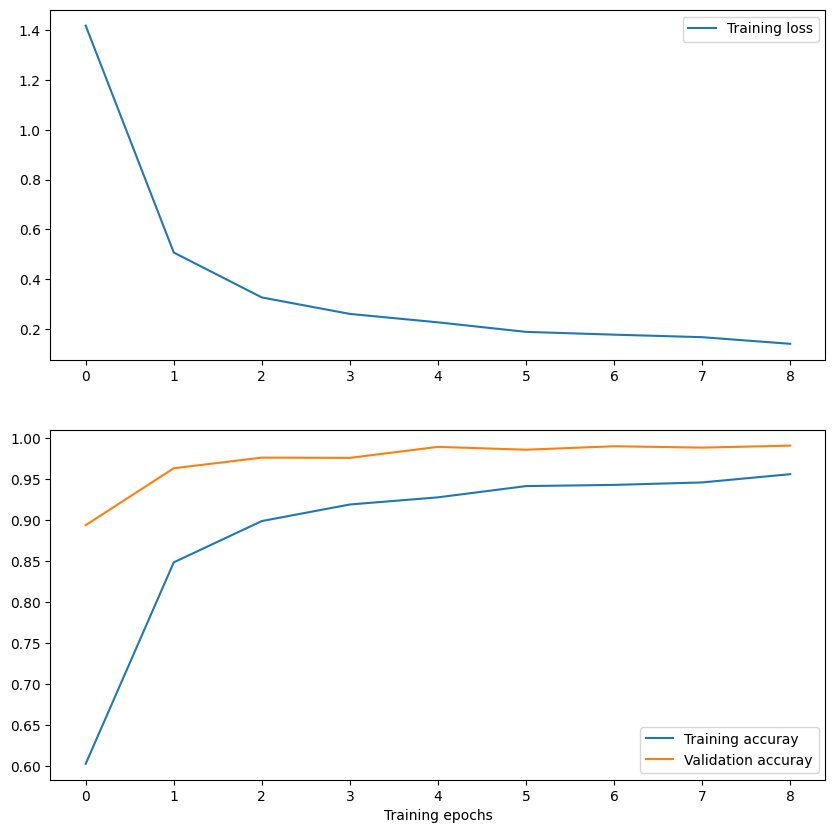

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(trainlosses)
plt.legend(['Training loss'])
plt.subplot(2,1,2)
plt.plot(trainaccs)
plt.plot(validaccs)
plt.xlabel('Training epochs')
plt.legend(['Training accuray','Validation accuray'])

## Testing of `my_best_model` will be done here

Validation (once again) of the trained model is put here as placeholder (should work!), will be replaced with testing.

In [ ]:
valid_acc = 0.0
for i, (images, labels) in enumerate(validloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = my_best_model(images)
    valid_acc += get_corrects(outputs, labels)

valid_acc /= len(validset)

print('Validation Accuracy: %.4f' %(valid_acc))

Validation Accuracy: 0.9907
